In [19]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import operator
import itertools

In [29]:
# Читаем данные
xlsx = pd.ExcelFile('data node VRP.xlsx')
#sheet1 = pd.read_excel(xlsx, 'Sheet20')
#sheet2 = pd.read_excel(xlsx, 'Sheet50')
sheet3 = pd.read_excel(xlsx, 'Sheet100')
sheet_vehicle = pd.read_excel(xlsx, 'Sheet_vehicle')

# Описываем данные
#nodes = sheet1.values # множество координат и количество товара в каждой вершине, который нужно довезти
#nodes = sheet2.values
nodes = sheet3.values
#print(nodes)
depot = nodes[len(nodes) - 1] # координаты и количество товара в депо
cities = nodes[:(len(nodes) - 1)] # координаты и количество товара в остальных вершин(городов)
vehicle = sheet_vehicle.values # первая колонка отвечает за номер траспортного средства
                        # вторая колонка это максимальная вместимость

tour = list(range(0, len(cities)))

In [30]:
# Функция для вычисления расстояния между двумя городами
def distance(x1, y1, x2, y2):
    res = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return res

# Функция для вычисление длины всего тура
def totaldistancetour(tour):
    d = 0
    for i in range(1, len(tour)):
        x1 = cities[int(tour[i - 1])][0]
        y1 = cities[int(tour[i - 1])][1]
        x2 = cities[int(tour[i])][0]
        y2 = cities[int(tour[i])][1]
        d = d + distance(x1, y1, x2, y2)
    
    x1 = cities[int(tour[len(tour) - 1])][0]
    y1 = cities[int(tour[len(tour) - 1])][1]
    x2 = depot[0]
    y2 = depot[1]
    d = d + distance(x1, y1, x2, y2)
    
    x1 = cities[int(tour[0])][0]
    y1 = cities[int(tour[0])][1]
    x2 = depot[0]
    y2 = depot[1]
    d = d + distance(x1, y1, x2, y2)
    return d

def subtourslice(tour, vehicle):
    #print("--------------------------------Начало работы функции--------------------------------")
    capacity_used = np.zeros(len(vehicle))
    k = 0
    slice = []
    mass = [] # список всех весов грузов для перевозки
    for i in range(len(vehicle)):
        # capacity_used[i] - начальный вес
        # vehicle[i][1] - это значение из колонки 8000, то есть максимальный объем
        # vehicle[i][0] - это первая колонка, то есть номер грузовика
        #print("Начальный суммарный вес: ", capacity_used[i])
        while((capacity_used[i] <= vehicle[i][1]) and (k <= (len(tour) - 1))):
            # cities[tour[k]][2] - кол-во груза, который грузовик везет в город k (третья колнка в первой таблице)
            # print("Номер города для входа: ", k)
            # print("Временный суммарный вес: ", capacity_used[i])
            # print("Вес груза, который нужно перевезти в текущий город: ", cities[tour[k]][2])
            capacity_used[i] += cities[int(tour[k])][2] # заполняем грузовик конкретным кол-вом груза для каждого города
            if(capacity_used[i] > vehicle[i][1]):
                # если кол-во груза, который нужно отвезти, больше чем вместимость грузовика, то вычитаем это кол-во груза
                capacity_used[i] -= cities[int(tour[k])][2]
                k -= 1 # это номер города после которого суммарный вес > объема грузовика и дальнейший вес груза не учитываем
                # print("Номер города, после которого суммарный вес > объема грузовика: ", k)
                # после такого города, нужно полностью очистить грузовик и дальше отправить его по городам
                slice.append(k) # запоминаем номер тура, чтобы повторно не проходить по такому же маршруту
                k += 1
                break
            k += 1
            #print(' ')
        #print(' ')
        mass.append(capacity_used[i])
    slice.append(k - 1)
    return(slice, mass)

# Что происходит в цикле while
# Мы на каждом шаге суммарный вес груза увеличиваем для каждого грузовика пока он не превысит максимальный объем вмесимости
# грузовика. Если это происходит, то мы запоминаем предыдущий номер города после которого общий вес превысиль обьем грузовика,
# возвращаемся к номеру города, на котором остановились и начинаем все заново.

# print(subtourslice(tour, vehicle))

In [31]:
slice, mass = subtourslice(tour, vehicle)

def subtour(slice, tour):
    sub = []
    # добавляем номера городов, после которых суммарный вес груза превышал объем грузовика
    sub.append(tour[:(slice[0] + 1)]) # создаем список от 0 до 8
    for i in range(0, len(slice) - 1):
        # нарежем маршруты городов до момента, пока суммарный вес груза не превысел объем грузовика
        sub.append(tour[(slice[i] + 1):(slice[i + 1] + 1)])
        # создает список от 9 до 15, потом от 16 до 20
    return sub

#print(subtour(slice, tour))

In [32]:
# Вычисление общей длины всех туров

sub = subtour(slice, tour)
def all_vechile_distance(sub):
    all_distance = reduce(operator.add, (totaldistancetour(x) for x in sub), 0)
    return all_distance

#all_vechile_distance(sub)

In [33]:
# Функция определения общего расстояния по данным туров и грузовиков
def tour_to_distance(tour, vehicle):
    u = subtourslice(tour, vehicle) # получаем спислок городов, после которых суммарный вес груза > объема грузовика
    v = subtour(u[0], tour) # получим тур из номеров городов, где u[0] это список из номеров городов, после которых суммарный вес груза > объема грузовика
    total = all_vechile_distance(v) # посчитаем суммарное расстояние между всеми городами в туре
    return total

#tour_to_distance(tour, vehicle)

#### Вспомогательные функции для алгоритма "Simulated Annealing"

In [34]:
def Initialize(count): # задаем список из count городов и случайно их перемешиваем
    solution = np.arange(count)
    np.random.shuffle(solution)
    return solution

def GenerateStateCandidate(current):
    new = current.copy()
    index_a = np.random.randint(len(current))
    index_b = np.random.randint(len(current))
    while index_b == index_a:
        index_b = np.random.randint(len(current))
    if(index_a > index_b):
        new[index_b:index_a] = np.flip(new[index_b:index_a])
    else:
        new[index_a:index_b] = np.flip(new[index_a:index_b])
    return new


### Алгоритм "Simulated Annealing"

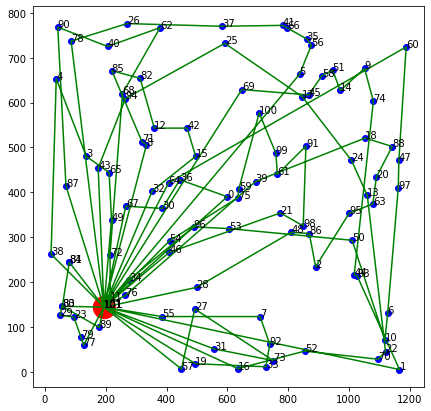

Начальный маршрут:  [ 19  33  92   7  55  67  30  36   0  78  26  37  41  66  35  56   5  77
  79  23  29  80  81  84  69  45  58  51  14   9  74  44  93   1  32  15
  42  12  82  85  71   8  46  21  98  91  61  99 100  59  75  54  49  65
   3   4  38  31  73  27  57  28  48  86   2  95  63  20  88  18  39  76
  34  96  53  50  10   6  97  47  60  64  16  52  70  22  13  24  17  25
  94  43  11  72  68  62  40  90  87  89  83]
Худшее расстояние:  67583.68017636598
Лучшее расстояние:  23604.828661811545
Лучший маршрут:  [ 19  33  92   7  55  67  30  36   0  78  26  37  41  66  35  56   5  77
  79  23  29  80  81  84  69  45  58  51  14   9  74  44  93   1  32  15
  42  12  82  85  71   8  46  21  98  91  61  99 100  59  75  54  49  65
   3   4  38  31  73  27  57  28  48  86   2  95  63  20  88  18  39  76
  34  96  53  50  10   6  97  47  60  64  16  52  70  22  13  24  17  25
  94  43  11  72  68  62  40  90  87  89  83]
Лучшее распределение объема груза по городам: ([4, 8, 16, 23, 33

In [35]:
%%time
T_end = 1
t_max = 100000

current_solution = Initialize(len(cities))
# print("Начальный маршрут: ", current_solution)
# print(" ")
currentEnergy = tour_to_distance(current_solution, vehicle) # вычисляем энергию для первого состояния
best_tour = np.copy(current_solution)
T = t_max
best_Energy = worst_Energy = currentEnergy
k = 0
while(T > T_end):  # на всякий случай ограничеваем количество итераций
# может быть полезно при тестировании сложных функций изменения температуры T       
    new_solution = GenerateStateCandidate(current_solution) # получаем новое решение
    candidateEnergy = tour_to_distance(new_solution, vehicle) # вычисляем его энергию
    best_Energy = min(best_Energy, candidateEnergy)
    worst_Energy = max(worst_Energy, candidateEnergy)

    if(candidateEnergy < currentEnergy): # если кандидат обладает меньшей энергией
        currentEnergy = candidateEnergy # то оно становится текущим состоянием
        current_solution = np.copy(new_solution)
        if(currentEnergy < best_Energy):
            best_tour = np.copy(current_solution)
    else:
        p = np.exp((currentEnergy - candidateEnergy) / T) # иначе, считаем вероятность
        if (p > np.random.uniform()): # и смотрим, осуществится ли переход
            currentEnergy = candidateEnergy
            best_tour = np. copy(current_solution)
            current_solution = np.copy(new_solution)
#     print("Шаг", k)
#     print("Текущее решение: ", current_solution)
#     print("Текущее расстояние: ", currentEnergy)
#     print(" ")
    T = t_max / (k + 1) # уменьшаем температуру
    k += 1
# print(" ")
# print("Худшее расстояние: ", worst_Energy)
# print("Лучшее расстояние: ", best_Energy)
# print("Лучший маршрут: ", best_tour)
# print(" ")
        
best_slice = subtourslice(best_tour, vehicle)
best_subtour = subtour(best_slice[0], best_tour)
# print("Лучшее распределение объема груза по городам:", best_slice)
# print("Лучшее разделение городов по отдельным маршрутам: ", best_subtour)
# print(time)

# совместим все маршруты
combine_subtour = np.concatenate([list(itertools.chain(x, [len(cities)])) for x in best_subtour])
combine_subtour = np.append([len(cities)],combine_subtour)

plt.figure(figsize = (7, 7))
plt.scatter([nodes[combine_subtour[i]][0] for i in range(0, len(combine_subtour))], [nodes[combine_subtour[i]][1] for i in range(0, len(combine_subtour))], c = 'b')
plt.plot([nodes[combine_subtour[i]][0] for i in range(0, len(combine_subtour))], [nodes[combine_subtour[i]][1] for i in range(0, len(combine_subtour))], c = 'g')
plt.scatter(nodes[combine_subtour[0]][0],nodes[combine_subtour[0]][1], color='red', s=500, marker='o')
for i in range(len(combine_subtour)):
    plt.annotate(combine_subtour[i], xy = (nodes[combine_subtour[i]][0], nodes[combine_subtour[i]][1]))
plt.show()
print("Начальный маршрут: ", current_solution)
print("Худшее расстояние: ", worst_Energy)
print("Лучшее расстояние: ", best_Energy)
print("Лучший маршрут: ", best_tour)
print("Лучшее распределение объема груза по городам:", best_slice)
print("Лучшее разделение городов по отдельным маршрутам: ", best_subtour)
print("k: ", worst_Energy/ best_Energy)

In [27]:
# # совместим все маршруты
# combine_subtour = np.concatenate([list(itertools.chain(x, [len(cities)])) for x in best_subtour])
# combine_subtour = np.append([len(cities)],combine_subtour)
# # combine_subtour= np.append(combine_subtour, [21])
# print(combine_subtour)

In [28]:
# plt.figure(figsize = (10, 10))
# plt.scatter([nodes[combine_subtour[i]][0] for i in range(0, len(combine_subtour))], [nodes[combine_subtour[i]][1] for i in range(0, len(combine_subtour))], c = 'b')
# plt.plot([nodes[combine_subtour[i]][0] for i in range(0, len(combine_subtour))], [nodes[combine_subtour[i]][1] for i in range(0, len(combine_subtour))], c = 'g')
# plt.scatter(nodes[combine_subtour[0]][0],nodes[combine_subtour[0]][1], color='red', s=500, marker='o')
# for i in range(len(combine_subtour)):
#     plt.annotate(combine_subtour[i], xy = (nodes[combine_subtour[i]][0], nodes[combine_subtour[i]][1]))
# plt.show()
# print("Худшее расстояние: ", worst_Energy)
# print("Лучшее расстояние: ", best_Energy)
# print("Лучший маршрут: ", best_tour)
# print("Лучшее распределение объема груза по городам:", best_slice)
# print("Лучшее разделение городов по отдельным маршрутам: ", best_subtour)
# print("k: ", worst_Energy/ best_Energy)